In [21]:
import pyxdf
import numpy as np
import subprocess
import os
from tqdm import tqdm
from datetime import datetime
import cv2

In [22]:
def segment_modalities_optimized(marker_timestamps, modality_timestamps_list, modality_data_list):
    """
    Optimized segmentation of data for multiple modalities based on marker timestamps, accommodating different sampling rates.

    :param marker_timestamps: Timestamps of markers.
    :param modality_timestamps_list: List of timestamps for each modality.
    :param modality_data_list: List of data for each modality to be segmented.
    :return: A list of lists of data segments for each modality.
    """
    # Convert marker timestamps to numpy array for efficient computation
    marker_timestamps = np.array(marker_timestamps)

    all_segments = []

    for modality_timestamps, modality_data in zip(modality_timestamps_list, modality_data_list):
        # Convert modality timestamps to numpy array
        modality_timestamps = np.array(modality_timestamps)

        # Find insertion points for each marker in the modality timestamps
        insert_points = np.searchsorted(modality_timestamps, marker_timestamps)
        segments = []
        for i in range(len(insert_points) - 1):
            # Extract and store the segment
            start_index = insert_points[i]
            end_index = insert_points[i + 1]
            segment = modality_data[start_index:end_index]
            segments.append(segment)

        # Handle the last segment, from the last marker to the end of the data stream
        if insert_points[-1] < len(modality_data):
            last_segment = modality_data[insert_points[-1]:]
            segments.append(last_segment)
        else:
            # If the last marker is exactly at or beyond the end of the data, append an empty segment
            segments.append([])

        all_segments.append(segments)

    return all_segments

def split_video(input_file, time_segments, output_folder):
    cap = cv2.VideoCapture(input_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    print(f'Video FPS: {fps}')
    print(f'Video duration: {duration} seconds')
    print(f'Number of time segments: {frame_count}')
    
    file_name = os.path.splitext(os.path.basename(input_file))[0]
    output_folder = os.path.join(output_folder, file_name)
    os.makedirs(output_folder, exist_ok=True)
    
    for (start_frame, end_frame, segment_name) in tqdm(time_segments):
        output_path = os.path.join(output_folder, f'{segment_name}.avi')

        # Set the video capture to the start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_frame))
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps,
                              (int(cap.get(3)), int(cap.get(4))))

        # Read and write frames from start to end
        for _ in range(int(start_frame), int(end_frame)):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        out.release()

    cap.release()

In [23]:
EXP_ROOT = "exp_data"
INPUT_ROOT = "input"
OUTPUT_ROOT = "output"
sub_id = "10"
DATA_FILE = os.path.join(EXP_ROOT,f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf")
RAW_VIDEO = os.path.join(INPUT_ROOT,f"{sub_id}.avi")
data, header = pyxdf.load_xdf(DATA_FILE)
# DATA_FILE = os.path.join(EXP_ROOT,"sub-P001_ses-S001_task-Default_run-001_eeg.xdf")
# DATA_FILE = os.path.join(f"C:\\Users\\anarg\\Documents\\CurrentStudy\\sub-{i}\\sub-{i}_task-hearing_run-001.xdf")
marker_stream = next(stream for stream in data if stream['info']['type'][0] == 'Markers')
video_stream = next(stream for stream in data if stream['info']['type'][0] == 'Video')
ppg_stream = next(stream for stream in data if stream['info']['type'][0] == 'PPG')
eeg_stream = next(stream for stream in data if stream['info']['type'][0] == 'EEG')

In [24]:
time_stamps_list = [video_stream['time_stamps'], ppg_stream['time_stamps']]
modality_list = [video_stream['time_series'].squeeze(), ppg_stream['time_series'].squeeze()]
segments = segment_modalities_optimized(marker_stream['time_stamps'],time_stamps_list,modality_list)
segmented_video_frames = segments[0]
segmented_ppg = segments[1]
markers = marker_stream['time_series']
print(f"Length of video segments: {len(segmented_video_frames)}, Length of PPG: {len(segmented_ppg)}, Length of Markers: {len(markers)}")
print(markers)
segment_arr = [(segmented_video_frames[i][0], segmented_video_frames[i][-1], markers[i][0]) for i in range(len(segmented_video_frames))]
print(segment_arr)

Length of video segments: 15, Length of PPG: 15, Length of Markers: 15
[['start'], ['pmt_stim'], ['pmt_poststim'], ['hlt_prestim-500Hz_10dB'], ['hlt_stim-500Hz_10dB'], ['hlt_poststim-500Hz_10dB'], ['hlt_response-500Hz_10dB'], ['let_prestim-500Hz_10dB'], ['let_stim-500Hz_10dB'], ['let_poststim-500Hz_10dB'], ['let_response-500Hz_10dB'], ['ast_prestim-name'], ['ast_stim-babycry'], ['ast_poststim-babycry'], ['end']]
[(130.0, 557.0, 'start'), (558.0, 617.0, 'pmt_stim'), (618.0, 1223.0, 'pmt_poststim'), (1224.0, 1372.0, 'hlt_prestim-500Hz_10dB'), (1373.0, 1432.0, 'hlt_stim-500Hz_10dB'), (1433.0, 1582.0, 'hlt_poststim-500Hz_10dB'), (1583.0, 1667.0, 'hlt_response-500Hz_10dB'), (1668.0, 1817.0, 'let_prestim-500Hz_10dB'), (1818.0, 1877.0, 'let_stim-500Hz_10dB'), (1878.0, 2027.0, 'let_poststim-500Hz_10dB'), (2028.0, 2288.0, 'let_response-500Hz_10dB'), (2289.0, 2438.0, 'ast_prestim-name'), (2439.0, 2498.0, 'ast_stim-babycry'), (2499.0, 2648.0, 'ast_poststim-babycry'), (2649.0, 2670.0, 'end')]


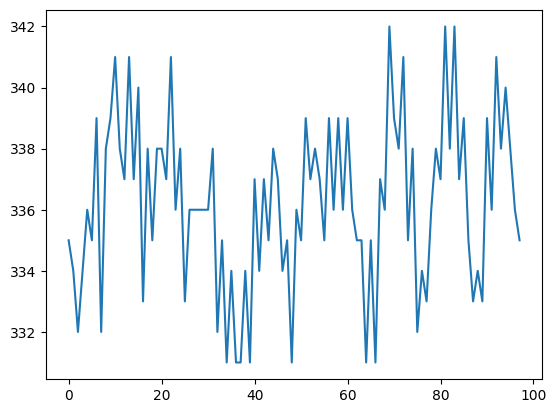

In [29]:
pp = ppg_stream['time_series'].squeeze()
import matplotlib.pyplot as plt
plt.plot(segmented_ppg[4])

In [ ]:
ppg_stream['time_series'].squeeze()

In [25]:
split_video(RAW_VIDEO, segment_arr, OUTPUT_ROOT)

Video FPS: 30.0
Video duration: 89.4 seconds
Number of time segments: 2682


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


In [ ]:
for s in segment_arr:
    print(f"Start: {s[0]:.2f}, End: {s[1]:.2f}, Marker: {s[2]}, Duration: {(s[1]-s[0])/30:.2f}")